In [5]:
import pandas as pd
import numpy as np
data = pd.read_csv('C:\\Users\\ADMIN\Projets\\train.csv', index_col="Loan_ID")

# 1 – Indexation booléenne
Nous voulons une liste de toutes les femmes qui ne sont pas diplômées et ont obtenu un prêt.

In [6]:
data.loc[(data["Gender"]=="Female") & (data["Education"]=="Not Graduate") & (data["Loan_Status"]=="Y"), ["Gender","Education","Loan_Status"]]

,Gender,Education,Loan_Status
Loan_ID,,,
LP001155,Female,Not Graduate,Y
LP001669,Female,Not Graduate,Y
LP001692,Female,Not Graduate,Y
LP001908,Female,Not Graduate,Y
LP002300,Female,Not Graduate,Y
LP002314,Female,Not Graduate,Y
LP002407,Female,Not Graduate,Y
LP002489,Female,Not Graduate,Y
LP002502,Female,Not Graduate,Y


# 2 – La fonction apply
C’est l’une des principales fonctions pour jouer avec les données et créer de nouvelles variables. apply retourne une valeur après avoir passé chaque ligne / colonne d’un DataFRame avec une fonction. La fonction peut être une fonction par défaut ou alors définie par l’utilisateur.

In [7]:
# Créer une nouvelle fonction qui détermine si la valeur en paramètre est manquante:
def num_missing(x):
    return sum(x.isnull())
# On applique cette fonction pour chaque colonne:
print("Valeurs manquantes par colonne:")
print(data.apply(num_missing, axis=0)) #axis=0 définit que la fonction sera bien appliquée sur chaque colonne
# Puis application pour chaque ligne:
print("\nValeurs manquantes par ligne:")
print(data.apply(num_missing, axis=1).head()) #axis=1 définit que la fonction sera bien appliquée sur chaque ligne

Valeurs manquantes par colonne:
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Valeurs manquantes par ligne:
Loan_ID
LP001002    1
LP001003    0
LP001005    0
LP001006    0
LP001008    0
dtype: int64


# 3 – Imputation des valeurs manquantes
La méthode fillna() le fait en une ligne. 
On l’utilise pour mettre à jour les valeurs manquantes avec la moyenne globale (mean) / mode / médiane (median) de la colonne. Imputons les colonnes Gender (sexe), Married (mariés) et Self_Employed (à son compte) avec leurs modes respectifs.

In [10]:
# Tout d'abord nous importons une fonction pour déterminer le mode
from scipy.stats import mode
data['Gender'].mode()

0    Male
dtype: object

Cela retourne à la fois le mode et le nombre. Rappelez-vous que le mode peut être un tableau car il peut y avoir plusieurs valeurs avec une fréquence élevée. Nous prendrons toujours le premier par défaut en utilisant:

In [11]:
data['Gender'].mode()[0]

'Male'

Maintenant, nous pouvons remplir les valeurs manquantes et vérifier en utilisant la technique # 2.



In [12]:
# Imputer les valeurs:
data['Gender'].fillna(data['Gender'].mode().iloc[0], inplace=True)
data['Married'].fillna(data['Married'].mode().iloc[0], inplace=True)
data['Self_Employed'].fillna(data['Self_Employed'].mode().iloc[0], inplace=True)
# Puis on re-teste les valeurs manquantes de nouveau pour valider:
print(data.apply(num_missing, axis=0))

Gender                0
Married               0
Dependents           15
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


Par conséquent, il est confirmé que les valeurs manquantes sont imputées. Veuillez noter qu’il s’agit de la forme d’imputation la plus primitive. D’autres techniques sophistiquées incluent la modélisation des valeurs manquantes, en utilisant des moyennes groupées (moyenne / mode / médiane).

#4 – Table Pivot
Pandas peut être utilisé pour créer des tableaux croisés dynamiques de style MS Excel. Par exemple, dans ce cas, une colonne clé est LoanAmount qui a des valeurs manquantes. Nous pouvons l’imputer en utilisant le montant moyen de chaque groupe Gender, Married et Self_Employed. La moyenne de la colonne LoanAmount de chaque groupe peut être déterminé comme suit:

In [13]:
# Utilisation d'un Pivot de Table
impute_grps = data.pivot_table(values=["LoanAmount"], index=["Gender","Married","Self_Employed"], aggfunc=np.mean)
print(impute_grps)

                              LoanAmount
Gender Married Self_Employed            
Female No      No             114.691176
               Yes            125.800000
       Yes     No             134.222222
               Yes            282.250000
Male   No      No             129.936937
               Yes            180.588235
       Yes     No             153.882736
               Yes            169.395833


# 5 – Multi-indexage
Si on regarde la résultat du 3e point, on remarque une propriété étrange. Chaque index est composé d’une combinaison de 3 valeurs. C’est ce qu’on appelle le multi-indexage. Cela aide à effectuer des opérations très rapidement.

En reprenant l’exemple du # 3, nous avons les valeurs pour chaque groupe mais elles n’ont pas été imputées.
Cela peut être fait en utilisant les différentes techniques apprises jusqu’à présent.

In [14]:
# Itérer seulement à travers les lignes avec des valeurs manquantes sur la colonne LoanAmount
for i,row in data.loc[data['LoanAmount'].isnull(),:].iterrows():
  ind = tuple([row['Gender'],row['Married'],row['Self_Employed']])
  data.loc[i,'LoanAmount'] = impute_grps.loc[ind].values[0]
# On vérifie les valeurs manquantes:
print(data.apply(num_missing, axis=0))

Gender                0
Married               0
Dependents           15
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


Fonction crosstab
Cette fonction est utilisée pour obtenir un premier aperçu des données. Ici, nous pouvons valider une hypothèse de base. Par exemple, dans ce cas, la colonne Credit_History devrait affecter de manière significative le statut du prêt. Ceci peut être testé en utilisant la tabulation croisée crosstab, exemple ci-dessous:

In [15]:
pd.crosstab(data["Credit_History"],data["Loan_Status"],margins=True)

Loan_Status,N,Y,All
Credit_History,,,
0.0,82,7,89
1.0,97,378,475
All,179,385,564


Ce sont des nombres absolus. Cependant, les pourcentages peuvent être plus intuitifs pour permettre une analyse rapide. Nous pouvons le faire en utilisant la fonction apply:

In [16]:
def percConvert(ser):
    return ser/float(ser[-1])
pd.crosstab(data["Credit_History"],data["Loan_Status"],margins=True).apply(percConvert, axis=1)

Loan_Status,N,Y,All
Credit_History,,,
0.0,0.921348,0.078652,1.0
1.0,0.204211,0.795789,1.0
All,0.317376,0.682624,1.0


Il est maintenant évident que les personnes ayant des antécédents de crédit ont beaucoup plus de chances d’obtenir un prêt: 80% des personnes ayant des antécédents de crédit ont obtenu un prêt, contre seulement 8% sans antécédents de crédit.

Mais ce n’est pas tout. Cela raconte une histoire intéressante. Puisque je sais qu’avoir des antécédents de crédit est très important, si je prédis que le statut du prêt est égal à Y pour ceux qui ont des antécédents de crédit et à N sinon. Étonnamment, nous aurons raison 82 + 378 = 460 fois sur 614, ce qui représente 75%!

Croyez-moi, augmenter la précision même de 0,001% au-delà de cette marque est une tâche ardue.

Remarque: 75% c’est sur le dataset train. Le dataset test sera légèrement différent mais proche. J’espère aussi que cela donne une certaine idée de la raison pour laquelle même une augmentation de 0,05% de la précision peut entraîner un saut de 500 rangs dans le classement Kaggle.

# 7 – Fusionner des DataFrames
La fusion de DataFrames devient essentielle lorsque nous devons rassembler des informations provenant de différentes sources. Prenons un cas hypothétique où les taux de propriété moyens (prix par mètre carré) sont disponibles pour différents types de propriété. Définissons un cadre de données comme suit:

In [17]:
prop_rates = pd.DataFrame([1000, 5000, 12000], index=['Rural','Semiurban','Urban'],columns=['rates'])

prop_rates

,rates
Rural,1000
Semiurban,5000
Urban,12000


In [18]:
data_merged = data.merge(right=prop_rates, how='inner',left_on='Property_Area',right_index=True, sort=False)

data_merged.pivot_table(values='Credit_History',index=['Property_Area','rates'], aggfunc=len)

,,Credit_History
Property_Area,rates,
Rural,1000,179.0
Semiurban,5000,233.0
Urban,12000,202.0


#8 – Trier des DataFrames

In [19]:
data_sorted = data.sort_values(['ApplicantIncome','CoapplicantIncome'], ascending=False)

data_sorted[['ApplicantIncome','CoapplicantIncome']].head(10)

,ApplicantIncome,CoapplicantIncome
Loan_ID,,
LP002317,81000,0.0
LP002101,63337,0.0
LP001585,51763,0.0
LP001536,39999,0.0
LP001640,39147,4750.0
LP002422,37719,0.0
LP001637,33846,0.0
LP001448,23803,0.0
LP002624,20833,6667.0


# 9 – Tracer des boîtes à moustache & des histogrammes
Beaucoup d’entre vous ignorent peut-être que les diagrammes en boîte et les histogrammes peuvent être directement tracés avec Pandas et qu’il n’est pas nécessaire d’appeler séparément la librairie matplotlib. C’est juste une commande sur une ligne. Par exemple, si nous voulons comparer la distribution des valeurs ApplicantIncome par les valeurs de Loan_Status:

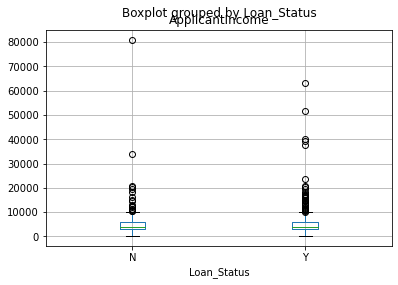

In [20]:
data.boxplot(column="ApplicantIncome",by="Loan_Status")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002A88E6E1070>,
      dtype=object)

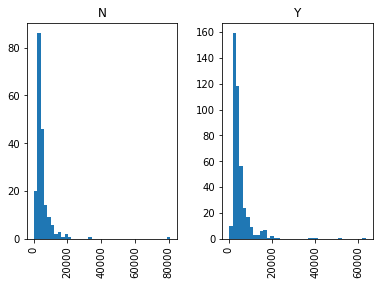

In [22]:
data.hist(column="ApplicantIncome",by="Loan_Status",bins=40)

# 10 – Fonction cut pour le regroupement de valeurs
Parfois, les valeurs numériques ont plus de sens si elles sont regroupées. Par exemple, si nous essayons de modéliser le trafic (nombre de voitures sur la route) avec l’heure du jour (minutes). La minute exacte d’une heure peut ne pas être très utile pour prévoir le trafic par rapport à la période réelle de la journée, telle que “Matin”, “Après-midi”, “Soirée”, “Nuit”, “Nuit tardive”. La modélisation du trafic de cette manière sera plus intuitive et évitera les sur-ajustements.

Nous définissons ici une fonction simple qui peut être réutilisée pour regrouper assez facilement n’importe quelle variable:

In [23]:
# Binning:
def binning(col, cut_points, labels=None):
    # Définir les valeurs min et max:
    minval = col.min()
    maxval = col.max()
    # Créer une liste en ajoutant min et max à cut_points
    break_points = [minval] + cut_points + [maxval]
    # Si aucun label, on utilise par défaut les labels 0 ... (n-1)
    if not labels:
        labels = range(len(cut_points)+1)
    # Regroupement en utilisant la fonction cut de Pandas
    colBin = pd.cut(col,bins=break_points,labels=labels,include_lowest=True)
    return colBin
cut_points = [90,140,190]
labels = ["low","medium","high","very high"]
data["LoanAmount_Bin"] = binning(data["LoanAmount"], cut_points, labels)
print(pd.value_counts(data["LoanAmount_Bin"], sort=False))

low          104
medium       273
high         146
very high     91
Name: LoanAmount_Bin, dtype: int64


# 11 – Codage des données nominales
Nous trouvons souvent le cas où nous devons modifier les catégories d’une variable nominale. Cela peut être dû à diverses raisons:

Certains algorithmes (comme la régression logistique) exigent que toutes les entrées soient numériques. Les variables nominales sont donc généralement codées 0, 1… (n-1)
Parfois, une catégorie peut être représentée de 2 manières. Par exemple la température peut être enregistrée comme“High”, “Medium”, “Low”, “H”, “low”. Ici, “High” et “H” se réfèrent à la même catégorie. De même, dans «Low» et «low», il n’y a qu’une différence de cas. Mais python les lirait comme des niveaux différents.
Certaines catégories peuvent avoir de très basses fréquences et il est généralement préférable de les combiner.
J’ai défini une fonction générique qui prend en entrée un dictionnaire et code les valeurs à l’aide de la fonction replace de Pandas.

In [24]:
# Définit une fonction générique en utilisant la fonction replace de Pandas
def coding(col, codeDict):
    colCoded = pd.Series(col, copy=True)
    for key, value in codeDict.items():
        colCoded.replace(key, value, inplace=True)
    return colCoded
 
# Coder LoanStatus avec Y=1 et N=0:
print('Avant codage:')
print(pd.value_counts(data["Loan_Status"]))
data["Loan_Status_Coded"] = coding(data["Loan_Status"], {'N':0,'Y':1})
print('\nAprès codage:')
print(pd.value_counts(data["Loan_Status_Coded"]))

Avant codage:
Y    422
N    192
Name: Loan_Status, dtype: int64

Après codage:
1    422
0    192
Name: Loan_Status_Coded, dtype: int64


# 12 – Itération sur les lignes d’un DataFrame
Ce n’est pas une opération fréquemment utilisée. Cependant, vous ne voulez pas rester coincé. Non? Il peut parfois être nécessaire de parcourir toutes les lignes à l’aide d’une boucle for. Par exemple, un problème courant auquel nous sommes confrontés est le traitement incorrect des variables en Python. Cela se produit généralement lorsque:

Les variables nominales avec des catégories numériques sont traitées comme des nombres.
Les variables numériques avec des caractères entrés dans l’une des lignes (en raison d’une erreur de données) sont considérées comme catégoriques.
Il est donc généralement conseillé de définir manuellement les types de colonne. Si nous vérifions les types de données de toutes les colonnes:

In [25]:
# Vérifier les types de données:
data.dtypes

Gender                 object
Married                object
Dependents             object
Education              object
Self_Employed          object
ApplicantIncome         int64
CoapplicantIncome     float64
LoanAmount            float64
Loan_Amount_Term      float64
Credit_History        float64
Property_Area          object
Loan_Status            object
LoanAmount_Bin       category
Loan_Status_Coded       int64
dtype: object

In [27]:
# Lecture du fichier:
colTypes = pd.read_csv('C:\\Users\\ADMIN\Projets\\datatypes.csv')
print(colTypes)

              feature         type
0              Gender  categorical
1             Married  categorical
2          Dependents  categorical
3           Education  categorical
4       Self_Employed  categorical
5     ApplicantIncome   continuous
6   CoapplicantIncome   continuous
7          LoanAmount   continuous
8    Loan_Amount_Term   continuous
9      Credit_History  categorical
10      Property_Area  categorical
11        Loan_Status  categorical


In [28]:
# Itérer à travers chaque ligne et assigner le type de variable
# Remarque: astype est utilisé pour assigner des types

for i, row in colTypes.iterrows():  # i: dataframe index; row: chaque ligne (row) au format series
    if row['type']=="categorical":
        data[row['feature']]=data[row['feature']].astype(np.object)
    elif row['type']=="continuous":
        data[row['feature']]=data[row['feature']].astype(np.float)
print(data.dtypes)

Gender                 object
Married                object
Dependents             object
Education              object
Self_Employed          object
ApplicantIncome       float64
CoapplicantIncome     float64
LoanAmount            float64
Loan_Amount_Term      float64
Credit_History         object
Property_Area          object
Loan_Status            object
LoanAmount_Bin       category
Loan_Status_Coded       int64
dtype: object


Maintenant, la colonne credit_history est modifiée en type object utilisé pour représenter les variables nominales avec Pandas.